In [ ]:
!pip install pytorch-transformers
!pip install pytorch_lightning

In [ ]:
!git clone https://github.com/shauli-ravfogel/nullspace_projection.git

fatal: destination path 'nullspace_projection' already exists and is not an empty directory.


In [ ]:
cd nullspace_projection/notebooks/

/content/nullspace_projection/notebooks


In [ ]:
cd /content/nullspace_projection

/content/nullspace_projection


In [ ]:
!git clone https://github.com/assemzh/NullitOut.git

fatal: destination path 'NullitOut' already exists and is not an empty directory.


In [ ]:
mkdir data/toxicity

In [ ]:
%load_ext autoreload
%autoreload 2
# sys.path.append("../src")
# sys.path.append("../data/embeddings")
# sys.path.append("../data/biasbios")
# sys.path.append("../data/embeddings/biasbios")
import sys
import src.classifier
import NullitOut.debias
import gensim
import codecs
import json
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import DictVectorizer
from pytorch_transformers import BertTokenizer, BertModel, BertForMaskedLM

import scipy
from scipy import linalg
from scipy import sparse
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier, SGDRegressor, Perceptron, LogisticRegression
from sklearn.utils import shuffle

%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

import warnings
warnings.filterwarnings("ignore")

import csv
from collections import defaultdict, Counter
from typing import List, Dict

import torch
from torch import utils

import pytorch_lightning as pl
from pytorch_lightning import Trainer
import copy
import pandas as pd
from gensim.models import FastText
import time
from gensim.scripts.glove2word2vec import glove2word2vec

STOPWORDS = set(["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip -P data/embeddings/
# ! wget http://nlp.stanford.edu/data/glove.42B.300d.zip -P data/embeddings/                
# ! unzip data/embeddings/glove.42B.300d.zip -d data/embeddings/ 

--2021-06-06 07:17:34--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1523785255 (1.4G) [application/zip]
Saving to: ‘data/embeddings/crawl-300d-2M.vec.zip’

crawl-300d-2M.vec.z 100%[===================>]   1.42G  56.8MB/s    in 29s     

2021-06-06 07:18:03 (50.6 MB/s) - ‘data/embeddings/crawl-300d-2M.vec.zip’ saved [1523785255/1523785255]



In [ ]:
!unzip data/embeddings/crawl-300d-2M.vec.zip -d data/embeddings/

Archive:  data/embeddings/crawl-300d-2M.vec.zip
  inflating: data/embeddings/crawl-300d-2M.vec  


In [ ]:
def load_dataset(path):
    
    with open(path, "r") as f:
        reader = csv.DictReader(f)
        data = list(reader)
    return data

def load_dictionary(path):
    
    with open(path, "r", encoding = "utf-8") as f:
        
        lines = f.readlines()
        
    k2v, v2k = {}, {}
    for line in lines:
        
        k,v = line.strip().split("\t")
        v = int(v)
        k2v[k] = v
        v2k[v] = k
    
    return k2v, v2k
    
def count_profs_and_gender(data: List[dict]):
    
    counter = defaultdict(Counter)
    for entry in data:
        gender, prof = entry["label_religion"], entry["toxicity"]
        counter[prof][gender] += 1
        
    return counter


# Train embeddings

In [ ]:
all_train = load_dataset("/content/nullspace_projection/NullitOut/train_religion.csv")

In [ ]:
import math
random.shuffle(all_train)
train_len = math.ceil(len(all_train)*0.8)
dev_len = math.ceil(len(all_train)*0.1)
test_len = len(all_train) - train_len - dev_len
print (train_len,dev_len,test_len)

train = all_train[:train_len]
dev = all_train[train_len:train_len+dev_len]
test = all_train[train_len+dev_len:]
print (len(train),len(dev),len(test))

25422 3178 3177
25422 3178 3177


In [ ]:
# p2i, i2p = load_dictionary("/content/nullspace_projection/data/biasbios/profession2index.txt")
# g2i, i2g = load_dictionary("/content/nullspace_projection/data/biasbios/gender2index.txt")

g2i = dict()
g2i['atheist'] = 0
g2i['buddhist'] = 1
g2i['christian'] = 2
g2i['hindu'] = 3
g2i['jewish'] = 4
g2i['muslim'] = 5
g2i['other_religion'] = 6
i2g = dict()
i2g[0] = 'atheist'
i2g[1] = 'buddhist'
i2g[2] = 'christian'
i2g[3] = 'hindu'
i2g[4] = 'jewish'
i2g[5] = 'muslim'
i2g[6] = 'other_religion'
print(g2i,i2g)

t2i = dict()
t2i['toxic'] = 1
t2i['non-toxic'] = 0
i2t = dict()
i2t[0] = 'non-toxic'
i2t[1] = 'toxic'
print(t2i,i2t)


{'atheist': 0, 'buddhist': 1, 'christian': 2, 'hindu': 3, 'jewish': 4, 'muslim': 5, 'other_religion': 6} {0: 'atheist', 1: 'buddhist', 2: 'christian', 3: 'hindu', 4: 'jewish', 5: 'muslim', 6: 'other_religion'}
{'toxic': 1, 'non-toxic': 0} {0: 'non-toxic', 1: 'toxic'}


In [ ]:
counter = count_profs_and_gender(train+dev+test)
print(counter)

defaultdict(<class 'collections.Counter'>, {'toxic': Counter({'christian': 8195, 'muslim': 7791, 'jewish': 2128, 'atheist': 297, 'buddhist': 85, 'hindu': 42, 'other_religion': 5}), 'non-toxic': Counter({'christian': 8760, 'muslim': 3026, 'jewish': 1111, 'atheist': 235, 'buddhist': 59, 'hindu': 42, 'other_religion': 1})})


In [ ]:
counter = count_profs_and_gender(train+dev+test)
a, b, c, h, j, m, o = 0., 0., 0., 0., 0., 0., 0.
tox2fem = dict()

for k, values in counter.items():
    print(k, values)
    a += values['atheist']
    b += values['buddhist']
    c += values['christian']
    h += values['hindu']
    j += values['jewish']
    m += values['muslim']
    o += values['other_religion']
    divisor = (values['atheist'] + values['buddhist'] + values['christian'] + values['hindu'] + values['jewish'] + values['muslim'] + values['other_religion'])
    if divisor != 0:
      tox2fem[k] = values['atheist']/divisor
    else:
      tox2fem[k] = 0
print(a / (a+b+c+h+j+m+o))
print(tox2fem)

toxic Counter({'christian': 8195, 'muslim': 7791, 'jewish': 2128, 'atheist': 297, 'buddhist': 85, 'hindu': 42, 'other_religion': 5})
non-toxic Counter({'christian': 8760, 'muslim': 3026, 'jewish': 1111, 'atheist': 235, 'buddhist': 59, 'hindu': 42, 'other_religion': 1})
0.016741668502375934
{'toxic': 0.016016825756350106, 'non-toxic': 0.017757291824089468}


### Get input representatons 

In [ ]:

def load_word_vectors(fname):
    
    model = KeyedVectors.load_word2vec_format(fname, binary=False)
    vecs = model.vectors
    words = list(model.vocab.keys())
    return model, vecs, words


def get_embeddings_based_dataset(data: List[dict], word2vec_model, t2i, filter_stopwords = False):
    
    X, Y = [], []
    unk, total = 0., 0.
    unknown = []
    vocab_counter = Counter()
    
    for entry in tqdm.tqdm_notebook(data, total = len(data)):
        
        y = t2i[entry["toxicity"]]
        words = entry["comment_text"].split(" ")
        if filter_stopwords:
            words = [w for w in words if w.lower() not in STOPWORDS]
            
        vocab_counter.update(words) 
        bagofwords = np.sum([word2vec_model[w] if w in word2vec_model else word2vec_model["unk"] for w in words], axis = 0)
        #print(bagofwords.shape)
        X.append(bagofwords)
        Y.append(y)
        total += len(words)
        
        unknown_entry = [w for w in words if w not in word2vec_model]
        unknown.extend(unknown_entry)
        unk += len(unknown_entry)
    
    X = np.array(X)
    Y = np.array(Y)
    print("% unknown: {}".format(unk/total))
    return X,Y,unknown,vocab_counter



In [ ]:
word2vec, vecs, words = load_word_vectors("/content/nullspace_projection/data/embeddings/crawl-300d-2M.vec")

In [ ]:
train[0]

OrderedDict([('id', '820942'),
             ('comment_text',
              '"he\'s a guy who puts a lot of effort into cultivating the Somalian and Muslim communities"\nWhich will translate into Liberal votes... perhaps the real reason for the appointment.'),
             ('toxicity', 'toxic'),
             ('label_religion', 'muslim')])

In [ ]:
X_train, Y_train, unknown_train, vocab_counter_train = get_embeddings_based_dataset(train, word2vec, t2i)
X_dev, Y_dev, unknown_dev, vocab_counter_dev =  get_embeddings_based_dataset(dev, word2vec, t2i)
X_test, Y_test, unknown_test, vocab_counter_test =  get_embeddings_based_dataset(test, word2vec, t2i)



% unknown: 0.11887208456741559



% unknown: 0.11756573192900992



% unknown: 0.11820106504189865


In [ ]:
train_embeddings = np.array([X_train, Y_train, unknown_train, vocab_counter_train])
np.save('/content/nullspace_projection/NullitOut/religion_train_embeddings.npy', train_embeddings)
dev_embeddings = np.array([X_dev, Y_dev, unknown_dev, vocab_counter_dev])
np.save('/content/nullspace_projection/NullitOut/religion_dev_embeddings.npy', dev_embeddings)
test_embeddings = np.array([X_test, Y_test, unknown_test, vocab_counter_test])
np.save('/content/nullspace_projection/NullitOut/religion_test_embeddings.npy', test_embeddings)

# Run with pre-trained Embeddings

In [ ]:
train_arr = np.load('/content/nullspace_projection/NullitOut/religion_train_embeddings.npy', allow_pickle=True)
X_train, Y_train, unknown_train, vocab_counter_train = train_arr[0], train_arr[1], train_arr[2], train_arr[3]
dev_arr = np.load('/content/nullspace_projection/NullitOut/religion_dev_embeddings.npy',allow_pickle=True)
X_dev, Y_dev, unknown_dev, vocab_counter_dev = dev_arr[0], dev_arr[1], dev_arr[2], dev_arr[3]
test_arr = np.load('/content/nullspace_projection/NullitOut/religion_test_embeddings.npy',allow_pickle=True)
X_test, Y_test, unknown_test, vocab_counter_test = test_arr[0], test_arr[1], test_arr[2], test_arr[3]

In [ ]:
def save_in_word2vec_format(vecs: np.ndarray, words: np.ndarray, fname: str):


    with open(fname, "w", encoding = "utf-8") as f:

        f.write(str(len(vecs)) + " " + "300" + "\n")
        for i, (v,w) in tqdm.tqdm_notebook(enumerate(zip(vecs, words))):

            vec_as_str = " ".join([str(x) for x in v])
            f.write(w + " " + vec_as_str + "\n")


vocab_bios, _ = list(zip(*vocab_counter_train.most_common(120000)))
words_set = set(words)
vocab_bios = [w for w in tqdm.tqdm_notebook(vocab_bios) if w in words_set]
vecs_for_vocab = np.array([word2vec[w] for w in tqdm.tqdm_notebook(vocab_bios)])
print("here")
save_in_word2vec_format(vecs_for_vocab, vocab_bios, "vecs.vocab.bios.txt")
word2vec_bios, _, _ = load_word_vectors("vecs.vocab.bios.txt")


here


In [ ]:

print("len train: {}; len dev: {}; len test: {}".format(len(train), len(dev), len(test)))
mean_train = np.mean(X_train, axis = 0, keepdims = True)
mean_dev = np.mean(X_dev, axis = 0, keepdims = True)
mean_test = np.mean(X_test, axis = 0, keepdims = True)

#X_train -= mean_train
#X_dev -= mean_dev
#X_test -= mean_test

len train: 25422; len dev: 3178; len test: 3177


## Classify by toxicity


In [ ]:
#clf = LinearSVC(max_iter = 10) #LogisticRegression()
#clf = SGDClassifier(warm_start = True, loss = 'log', n_jobs = 64, max_iter = 250, random_state = 0)

clf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", fit_intercept = True,
                         verbose = 10, max_iter = 5, n_jobs = 64, random_state = 1)
# clf = SGDClassifier(loss= 'log', max_iter= 3000, fit_intercept= True, class_weight= None, n_jobs= 100)
# clf = LinearSVC(max_iter = 50) #LogisticRegression()

start = time.time()
idx = np.random.rand(X_train.shape[0]) < 1.0
clf.fit(X_train[idx], Y_train[idx])
print("time: {}".format(time.time() - start))
print(clf.score(X_dev, Y_dev))
print(clf.score(X_test, Y_test))
clf_original = copy.deepcopy(clf)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 0 seconds
time: 0.3435966968536377
0.6941472624292008
0.6874409820585458


[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.3s finished


In [ ]:
print(clf.score(X_test, Y_test))


0.6874409820585458


### Perform debiasing

In [ ]:
pwd

'/content/nullspace_projection'

In [ ]:
import NullitOut.debias  as debias

In [ ]:
def get_projection_matrix(num_clfs, X_train, Y_train, X_dev, Y_dev, Y_train_task, Y_dev_task, dim, all_data_prob, by_class = False):

    is_autoregressive = True
    min_acc = 0.
    dim = 300
    n = num_clfs
    random_subset = 1
    start = time.time()
    TYPE= "logistic"
    penalty = "l2"
    MLP = False
    
    if MLP:
        x_train_gender = np.matmul(X_train, clf.coefs_[0]) + clf.intercepts_[0]
        x_dev_gender = np.matmul(X_dev, clf.coefs_[0]) + clf.intercepts_[0]
    else:
        x_train_gender = X_train.copy()
        x_dev_gender = X_dev.copy()
        
    
    if TYPE == "sgd":
        print("using sgd")
        gender_clf = SGDClassifier
        params = {'alpha': 0.01, 'penalty': penalty, 'loss': 'hinge', 'fit_intercept': True, 'class_weight': "balanced", 'n_jobs': 16}
    elif TYPE == "svm":
        gender_clf = LinearSVC
        params = {'fit_intercept': True, 'C': 0.3, 'class_weight': None, "dual": False}
    elif TYPE == "perceptron":
        gender_clf = Perceptron
        params = {'max_iter': 1000, 'fit_intercept': True, 'class_weight': None}
    elif TYPE == "logistic":
        gender_clf = LogisticRegression
        params = {}
        
    result = debias.get_debiasing_projection(gender_clf, params, n, dim, is_autoregressive, min_acc,
                                              x_train_gender, Y_train, x_dev_gender, Y_dev,
                                       Y_train_main=Y_train_task, Y_dev_main=Y_dev_task, 
                                        by_class = by_class, X_test=X_test, Y_test=Y_test)
    print("time: {}".format(time.time() - start))
    return result

# was c=0.15, num_clfs=130
num_clfs = 15
Y_dev_religion = np.array([g2i[d["label_religion"]] for d in dev])
Y_test_religion = np.array([g2i[d["label_religion"]] for d in test])
Y_train_religion = np.array([g2i[d["label_religion"]] for d in train])
P, rowspace_projs, Ws, accuracies, toxicity_accuracies, predictions = get_projection_matrix(num_clfs, X_train, Y_train_religion, X_dev, Y_dev_religion, Y_train, Y_dev, 300, 0.0, by_class= True)



iteration: 0, accuracy: 0.8835098335854765:   0%|          | 0/15 [00:02<?, ?it/s][Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.6s finished
iteration: 0, accuracy: 0.8835098335854765:   7%|▋         | 1/15 [00:03<00:49,  3.52s/it]

max_iter reached after 1 seconds


iteration: 1, accuracy: 0.8434190620272315:   7%|▋         | 1/15 [00:05<00:49,  3.52s/it][Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.5s finished
iteration: 1, accuracy: 0.8434190620272315:  13%|█▎        | 2/15 [00:07<00:45,  3.54s/it]

max_iter reached after 0 seconds


iteration: 2, accuracy: 0.7851739788199698:  13%|█▎        | 2/15 [00:09<00:45,  3.54s/it][Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.6s finished
iteration: 2, accuracy: 0.7851739788199698:  20%|██        | 3/15 [00:10<00:42,  3.53s/it]

max_iter reached after 1 seconds


iteration: 3, accuracy: 0.7753403933434191:  20%|██        | 3/15 [00:12<00:42,  3.53s/it][Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.6s finished
iteration: 3, accuracy: 0.7753403933434191:  27%|██▋       | 4/15 [00:14<00:38,  3.51s/it]

max_iter reached after 0 seconds


iteration: 4, accuracy: 0.6740301724137931:  27%|██▋       | 4/15 [00:17<00:38,  3.51s/it][Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.6s finished
iteration: 4, accuracy: 0.6740301724137931:  33%|███▎      | 5/15 [00:18<00:38,  3.83s/it]

max_iter reached after 1 seconds


iteration: 5, accuracy: 0.6293103448275862:  33%|███▎      | 5/15 [00:22<00:38,  3.83s/it][Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.6s finished
iteration: 5, accuracy: 0.6293103448275862:  40%|████      | 6/15 [00:23<00:36,  4.04s/it]

max_iter reached after 0 seconds


iteration: 6, accuracy: 0.708018154311649:  40%|████      | 6/15 [00:25<00:36,  4.04s/it] [Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.6s finished
iteration: 6, accuracy: 0.708018154311649:  47%|████▋     | 7/15 [00:26<00:30,  3.87s/it]

max_iter reached after 1 seconds


iteration: 7, accuracy: 0.5867456896551724:  47%|████▋     | 7/15 [00:30<00:30,  3.87s/it][Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.6s finished
iteration: 7, accuracy: 0.5867456896551724:  53%|█████▎    | 8/15 [00:31<00:28,  4.07s/it]

max_iter reached after 0 seconds


iteration: 8, accuracy: 0.546875:  53%|█████▎    | 8/15 [00:34<00:28,  4.07s/it]          [Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.6s finished
iteration: 8, accuracy: 0.546875:  60%|██████    | 9/15 [00:35<00:25,  4.17s/it]

max_iter reached after 1 seconds


iteration: 9, accuracy: 0.6724659606656581:  60%|██████    | 9/15 [00:37<00:25,  4.17s/it][Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.6s finished
iteration: 9, accuracy: 0.6724659606656581:  67%|██████▋   | 10/15 [00:39<00:19,  3.98s/it]

max_iter reached after 0 seconds


iteration: 10, accuracy: 0.6717095310136157:  67%|██████▋   | 10/15 [00:41<00:19,  3.98s/it][Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.6s finished
iteration: 10, accuracy: 0.6717095310136157:  73%|███████▎  | 11/15 [00:42<00:15,  3.84s/it]

max_iter reached after 1 seconds


iteration: 11, accuracy: 0.6633888048411498:  73%|███████▎  | 11/15 [00:44<00:15,  3.84s/it][Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.6s finished
iteration: 11, accuracy: 0.6633888048411498:  80%|████████  | 12/15 [00:46<00:11,  3.75s/it]

max_iter reached after 0 seconds


iteration: 12, accuracy: 0.5032327586206896:  80%|████████  | 12/15 [00:49<00:11,  3.75s/it][Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.6s finished
iteration: 12, accuracy: 0.5032327586206896:  87%|████████▋ | 13/15 [00:50<00:08,  4.01s/it]

max_iter reached after 1 seconds


iteration: 13, accuracy: 0.48760775862068967:  87%|████████▋ | 13/15 [00:54<00:08,  4.01s/it][Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.6s finished
iteration: 13, accuracy: 0.48760775862068967:  93%|█████████▎| 14/15 [00:55<00:04,  4.17s/it]

max_iter reached after 1 seconds


iteration: 14, accuracy: 0.6573373676248109:  93%|█████████▎| 14/15 [00:57<00:04,  4.17s/it] [Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.6s finished
iteration: 14, accuracy: 0.6573373676248109: 100%|██████████| 15/15 [00:58<00:00,  3.93s/it]

max_iter reached after 0 seconds
time: 59.048025131225586


# Plot results

In [ ]:
atheist_ind = np.where(Y_test_religion == 0)
buddhist_ind = np.where(Y_test_religion == 1)
christian_ind = np.where(Y_test_religion == 2)
hindu_ind = np.where(Y_test_religion == 3)
jewish_ind = np.where(Y_test_religion == 4)
muslim_ind = np.where(Y_test_religion == 5)




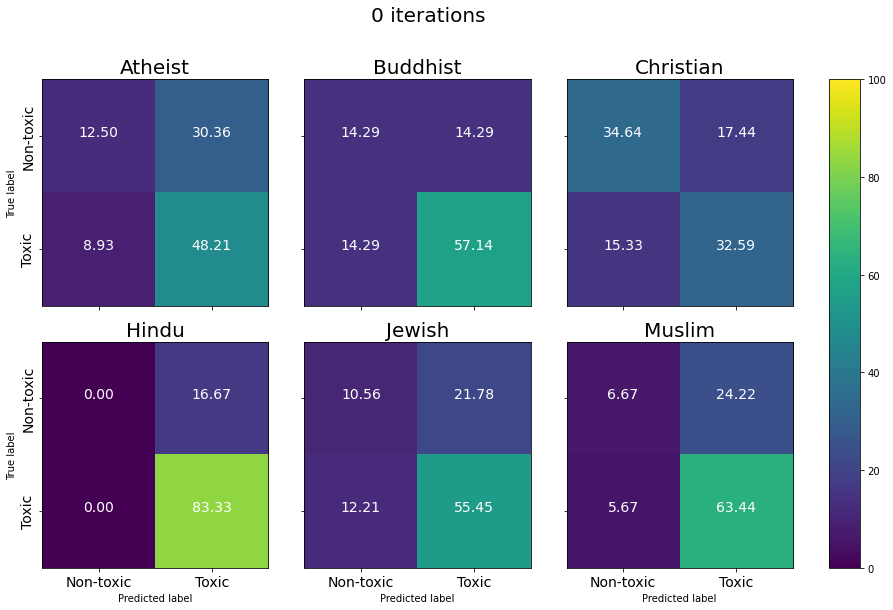

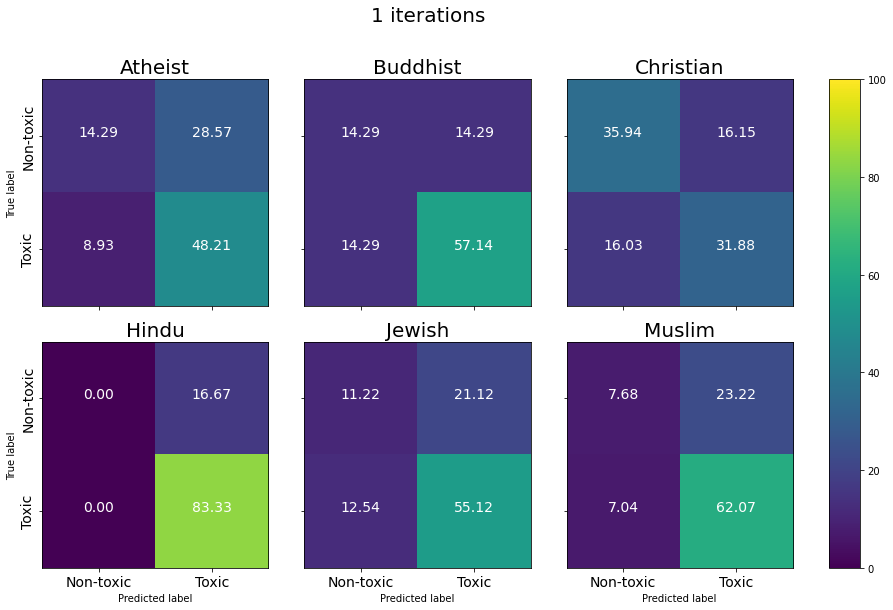

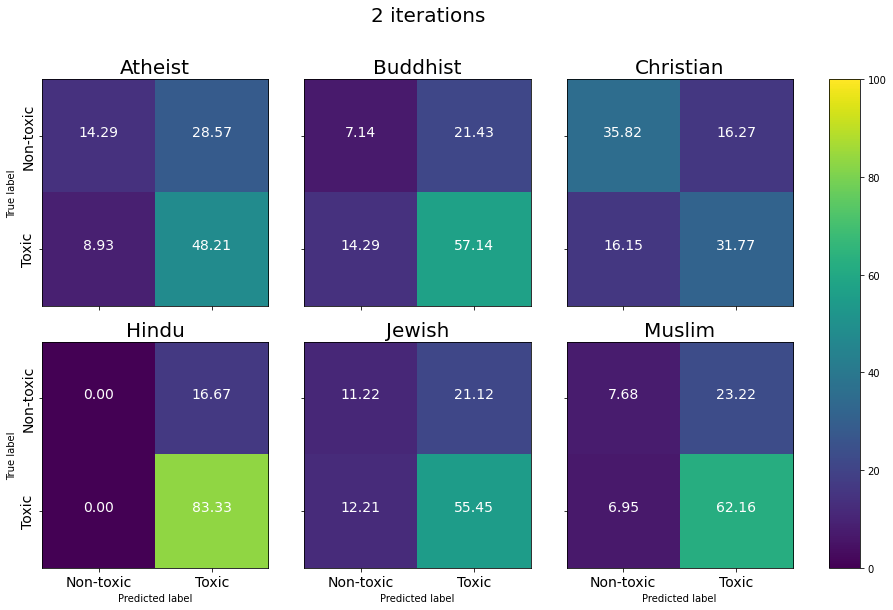

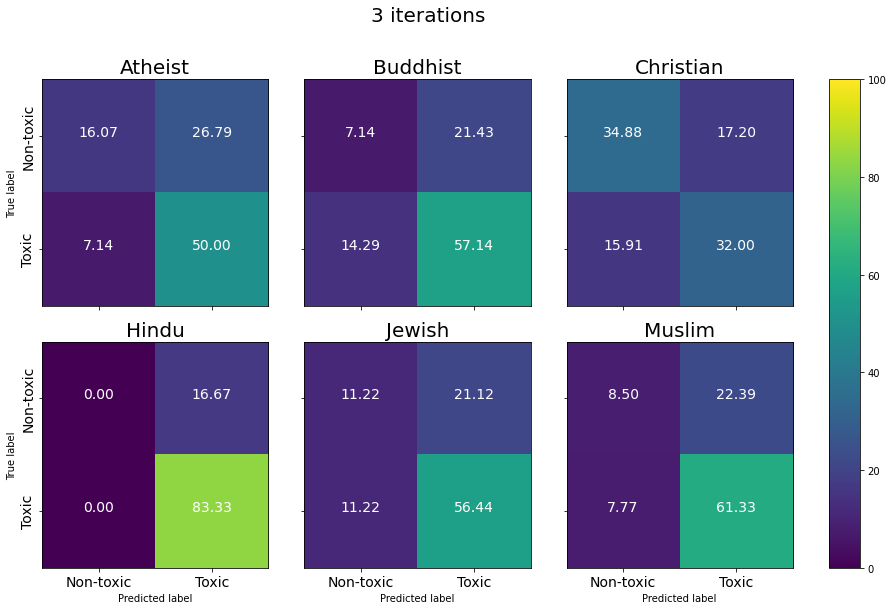

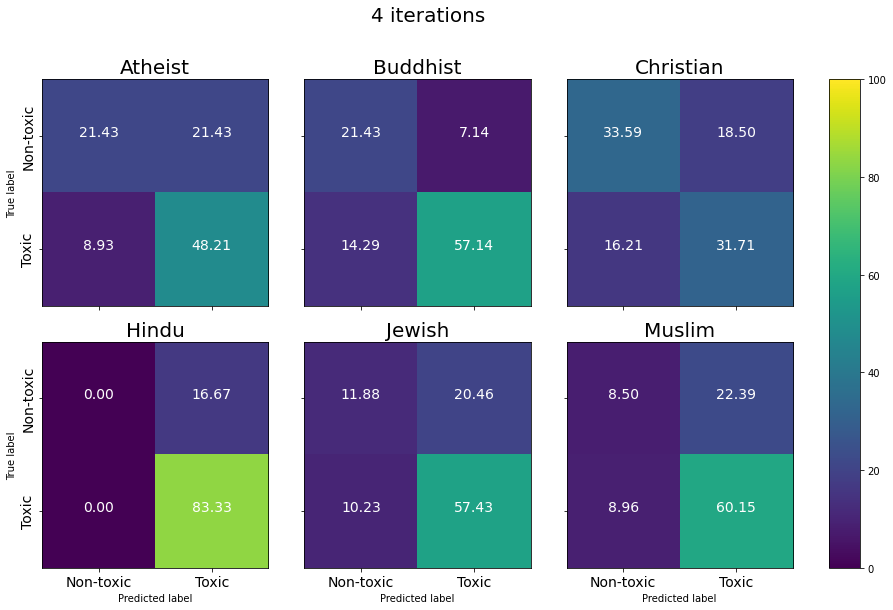

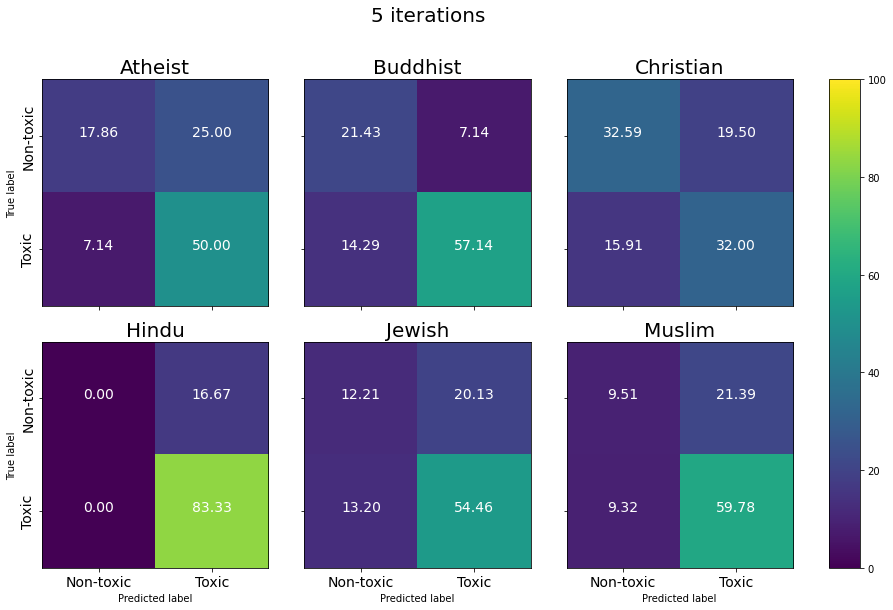

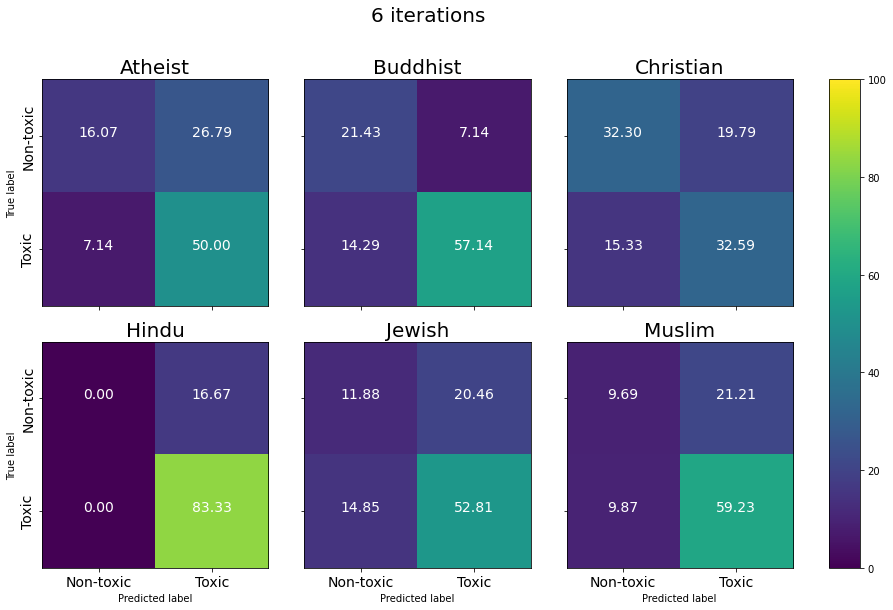

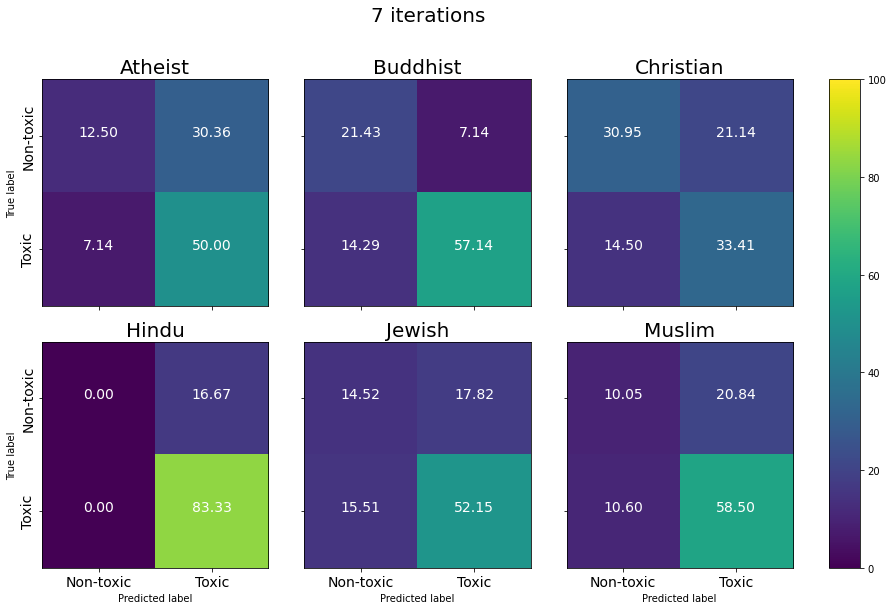

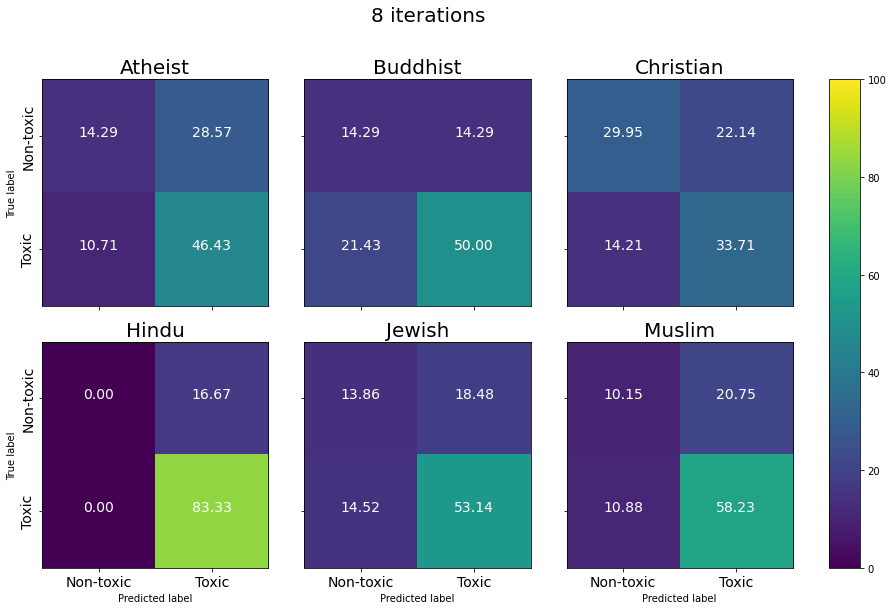

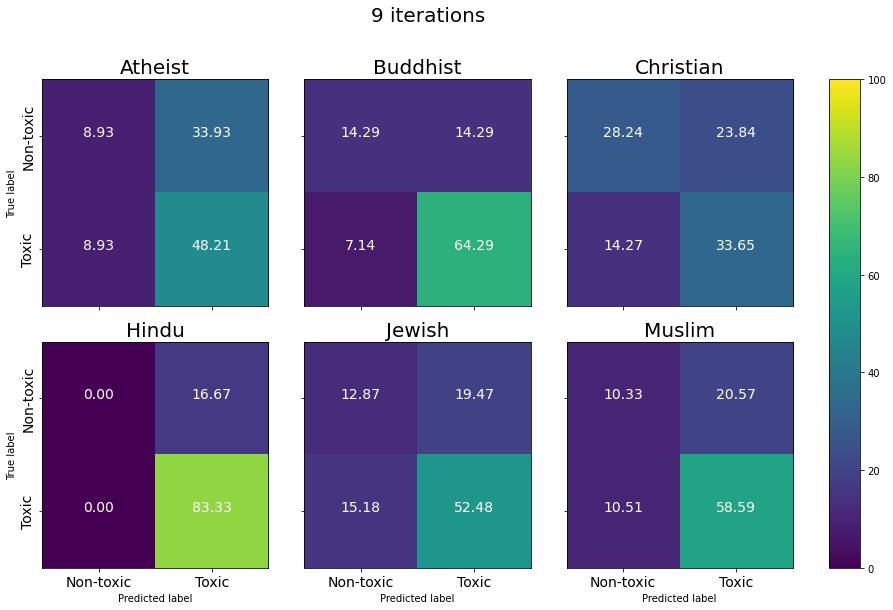

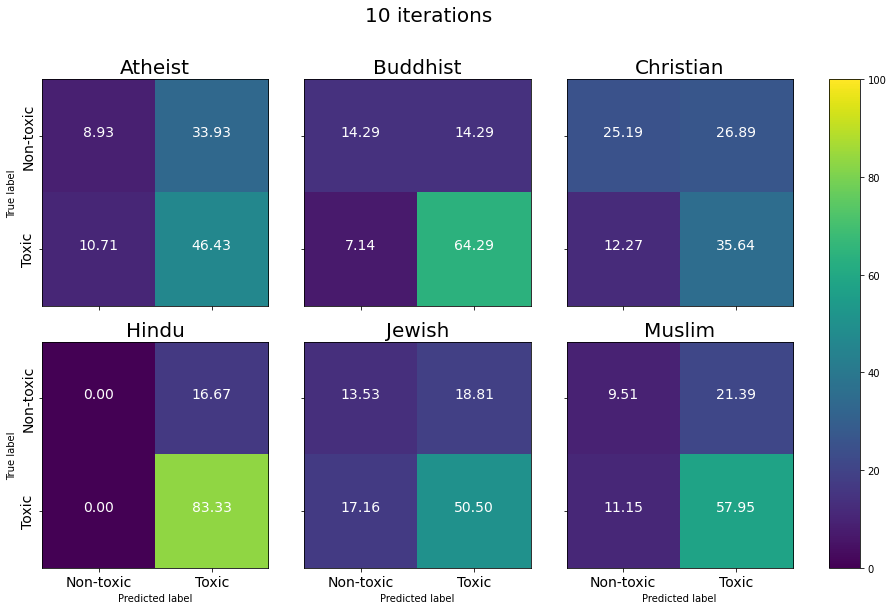

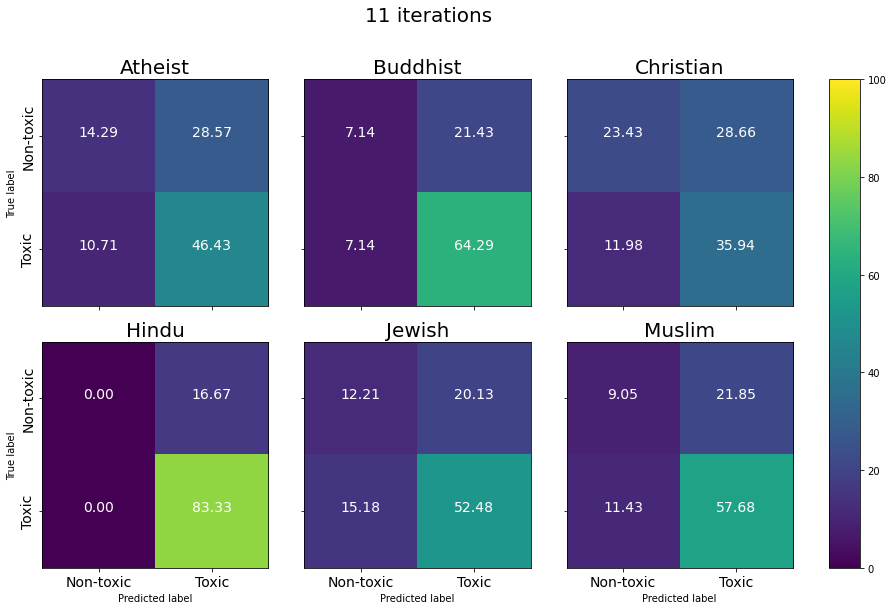

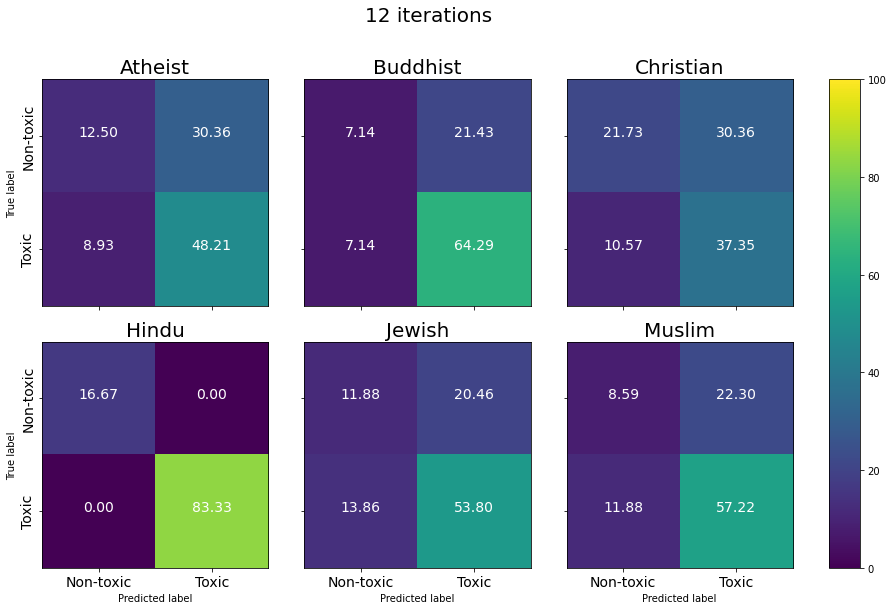

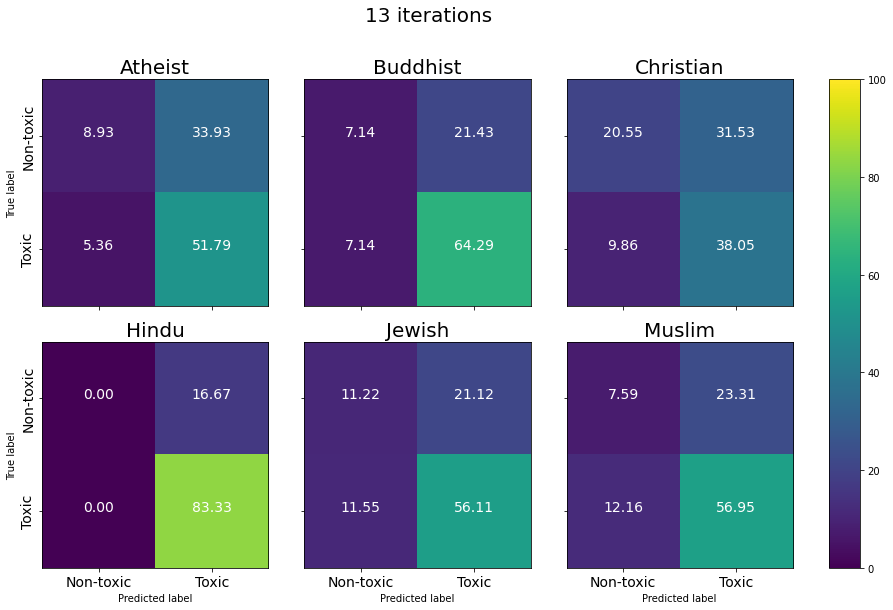

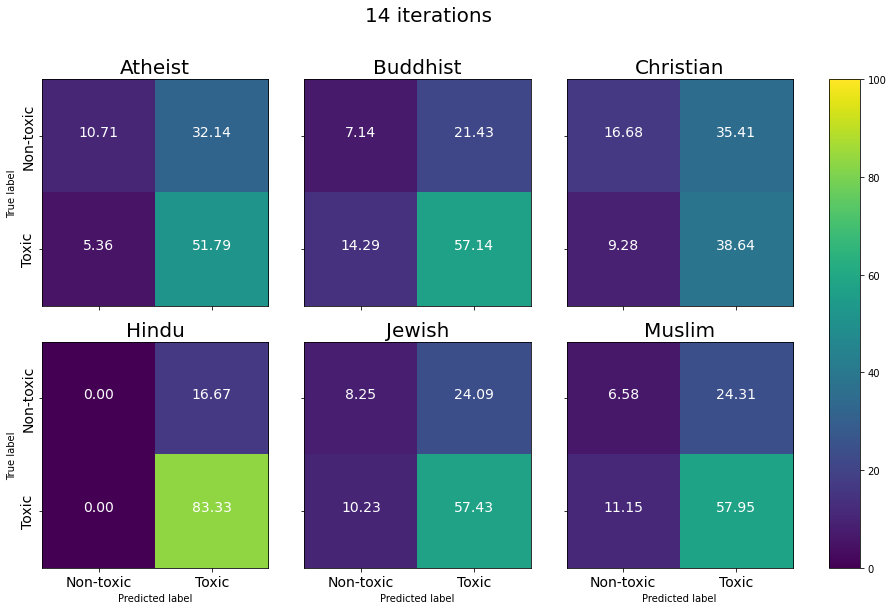

In [ ]:
import itertools
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.gridspec as gridspec
from sklearn.metrics import confusion_matrix

classes = ["Non-toxic", "Toxic"]
for num in range(num_clfs):
  fig = plt.figure(figsize=(15, 10))
  grid = ImageGrid(fig, 111,        # as in plt.subplot(111)
                  nrows_ncols=(2,3),
                  axes_pad=0.5,
                  cbar_location="right",
                  cbar_mode="single",
                  cbar_size="7%",
                  cbar_pad=0.5,
                  )
  
  fig.subplots_adjust(wspace=0.1, hspace=0)
  indices = [atheist_ind, buddhist_ind, christian_ind, hindu_ind, jewish_ind, muslim_ind, other_ind]
  protected_class = ['Atheist','Buddhist','Christian','Hindu','Jewish','Muslim']
  for i, ax in enumerate(grid[:7]):
      cm = confusion_matrix(Y_test[indices[i]], predictions[num][indices[i]])
      cm = cm/Y_test[indices[i]].shape[0]*100
      im = ax.imshow(cm, vmin=0, vmax=100,interpolation='nearest',)
      ax.set_title("{}".format(protected_class[i]), fontsize=20)  # ax.___ instead of plt.___
      tick_marks = np.arange(2)
      ax.set_xticks(tick_marks,)  # Warning: different signature for [x|y]ticks in pyplot and OO interface
      ax.set_xticklabels(classes, rotation=0, fontsize= 14)
      ax.set_yticks(tick_marks)
      ax.set_yticklabels(classes,rotation=90, fontsize= 14,va='center')

      for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          ax.text(j, i, format(cm[i, j],'.2f'),
                  horizontalalignment="center",
                  color="white", fontsize= 14)

      ax.set_ylabel('True label')
      ax.set_xlabel('Predicted label')
  fig.suptitle('{} iterations'.format(num), fontsize=20, ha='center',x=0.4, y=.95,)

  fig.tight_layout()
  fig.subplots_adjust(right=0.8)
  fig.colorbar(im, cax=ax.cax)
  plt.savefig('/content/nullspace_projection/NullitOut/religion_confusion_matrix_{}.png'.format(num+1), format='png')
  plt.show()

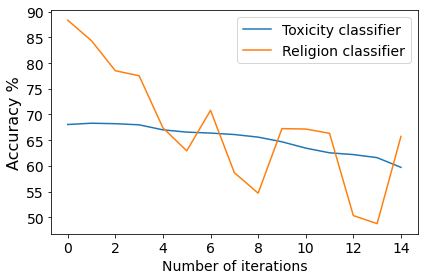

In [ ]:
import matplotlib.pylab as plt
gen_output = sorted(accuracies.items()) # sorted by key, return a list of tuples
tox_output = sorted(toxicity_accuracies.items()) # sorted by key, return a list of tuples

x, y = zip(*tox_output) # unpack a list of pairs into two tuples
plt.plot(x, tuple([z * 100 for z in y]), label='Toxicity classifier')
x1, y1 = zip(*gen_output) # unpack a list of pairs into two tuples
plt.plot(x1, tuple([z * 100 for z in y1]), label='Religion classifier')
plt.tight_layout()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Accuracy %",fontsize=16)
plt.xlabel("Number of iterations",fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('/content/nullspace_projection/NullitOut/religion_accuracy_plot.png', format='png', dpi=100)
plt.show()

In [ ]:
!zip -r /content/NullitOut.zip /content/nullspace_projection/NullitOut/gender/

  adding: content/nullspace_projection/NullitOut/gender/ (stored 0%)
  adding: content/nullspace_projection/NullitOut/gender/conf_matrix/ (stored 0%)
  adding: content/nullspace_projection/NullitOut/gender/conf_matrix/gender_confusion_matrix_10.png (deflated 8%)
  adding: content/nullspace_projection/NullitOut/gender/conf_matrix/gender_confusion_matrix_2.png (deflated 8%)
  adding: content/nullspace_projection/NullitOut/gender/conf_matrix/gender_confusion_matrix_15.png (deflated 8%)
  adding: content/nullspace_projection/NullitOut/gender/conf_matrix/gender_confusion_matrix_4.png (deflated 8%)
  adding: content/nullspace_projection/NullitOut/gender/conf_matrix/gender_confusion_matrix_3.png (deflated 8%)
  adding: content/nullspace_projection/NullitOut/gender/conf_matrix/gender_confusion_matrix_5.png (deflated 8%)
  adding: content/nullspace_projection/NullitOut/gender/conf_matrix/gender_confusion_matrix_7.png (deflated 8%)
  adding: content/nullspace_projection/NullitOut/gender/conf_mat

## Additional investigations

In [ ]:
! pip install pickle-mixin

  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-cp37-none-any.whl size=6007 sha256=aaa87a636814f64bdb54e1856cc2e175d7313d8ad385ca39ac60aab0bf11fc64
  Stored in directory: /root/.cache/pip/wheels/cd/05/42/71de70fa36b9cbb7657bb5793a16f8028c1cdc1bdd3b8e1ac3
Successfully built pickle-mixin


In [ ]:
import pickle
with open("P.bios.fasttext.{}.svm.pickle".format(num_clfs), "wb") as f:
    
    pickle.dump(P, f)
    
np.linalg.norm(Ws[-1])

2.287310059187333e-13

In [ ]:
Ws[-50].dot(Ws[0].T)

array([[ 2.35663421e-17, -7.03946081e-16,  1.92891126e-15],
       [-1.19935565e-18,  6.24728759e-16, -1.75027647e-15],
       [-8.12871668e-17, -1.11003265e-15,  3.45808854e-15]])

In [ ]:
gender_clf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial', fit_intercept = True,
                         verbose = 10, max_iter = 7, n_jobs = 64, random_state = 1)

gender_clf.fit(P.dot(X_train.T).T, Y_train_gender)
gender_clf.score(P.dot(X_dev.T).T, Y_dev_gender)

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 2 seconds


[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    1.3s finished


0.7158418186123608

In [ ]:
gender_clf.score(P.dot(X_train.T).T, Y_train_gender)

0.7150849564857025

### Perform finetuning

In [ ]:

clf = LogisticRegression(warm_start = True, penalty = 'l2',
                         solver = "sag", multi_class = 'multinomial', fit_intercept = True,
                         verbose = 10, max_iter = 6, n_jobs = 64, random_state = 0, class_weight = None)
# 5
#clf = SGDClassifier(verbose=10, n_jobs = 32)
clf.fit(P.dot(X_train.T).T, Y_train)
#clf.fit(X_train, Y_train)


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


max_iter reached after 1 seconds


[Parallel(n_jobs=64)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=64)]: Done   1 out of   1 | elapsed:    0.9s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=6,
                   multi_class='multinomial', n_jobs=64, penalty='l2',
                   random_state=0, solver='sag', tol=0.0001, verbose=10,
                   warm_start=True)

In [ ]:
print(clf.score(P.dot(X_test.T).T, Y_test))

0.549265750828991


#### test again

In [ ]:
def get_TPR(y_pred, y_true, p2i, i2p, gender):
    
    scores = defaultdict(Counter)
    prof_count_total = defaultdict(Counter)
    
    assert len(y_pred) == len(y_true) == len(gender)
               
    for y_hat, y, g in zip(y_pred, y_true, gender):
                
        if y == y_hat:
            
            scores[i2p[y]][g] += 1
        
        prof_count_total[i2p[y]][g] += 1
    
    tprs = defaultdict(dict)
    tprs_change = dict()
    tprs_ratio = []
    
    for profession, scores_dict in scores.items():
        
        good_m, good_f = scores_dict["male"], scores_dict["female"]
        prof_total_f = prof_count_total[profession]["female"]
        prof_total_m = prof_count_total[profession]["male"]
        tpr_m = (good_m) / prof_total_m
        tpr_f = (good_f) / prof_total_f
        
        tprs[profession]["male"] = tpr_m
        tprs[profession]["female"] = tpr_f
        tprs_ratio.append(0)
        tprs_change[profession] = tpr_f - tpr_m
        
    return tprs, tprs_change, np.mean(np.abs(tprs_ratio))

def get_FPR(y_pred, y_true, p2i, i2p, gender):
    
    fp = defaultdict(Counter)
    neg_count_total = defaultdict(Counter)
    pos_count_total = defaultdict(Counter)
    
    
               
    for y_hat, y, g in zip(y_pred, y_true, gender):
        
        if y != y_hat:
            
            fp[i2p[y_hat]][g] += 1 # count false positives for y_hat
        
        neg_count_total[i2p[y_hat]][g] += 1 # count "not y_hat"
                
    fprs = defaultdict(dict)
    fprs_change = dict()
    fprs_ratio = []
    
    #print(prof_count_total)
    
    for profession, scores_dict in fp.items():
        
        good_m, good_f = scores_dict["male"], scores_dict["female"]
        prof_total_f = neg_count_total[profession]["female"]
        prof_total_m = neg_count_total[profession]["male"]
        print(profession)
        fpr_m = (good_m+good_f) / prof_total_m
        fpr_f = (good_m+good_f) / prof_total_f
        
        fprs[profession]["male"] = fpr_m
        fprs[profession]["female"] = fpr_f
        fprs_ratio.append(0)
        fprs_change[profession] = fpr_m - fpr_f
        
    return fprs, fprs_change, np.mean(np.abs(fprs_ratio))    
    
def similarity_vs_tpr(tprs, word2vec, title, measure, prof2fem):
    
    professions = list(tprs.keys())
    #
    """ 
    sims = dict()
    gender_direction = word2vec["he"] - word2vec["she"]
    
    for p in professions:
        sim = word2vec.cosine_similarities(word2vec[p], [gender_direction])[0]
        sims[p] = sim
    """
    tpr_lst = [tprs[p] for p in professions]
    sim_lst = [prof2fem[p] for p in professions]

    #professions = [p.replace("_", " ") for p in professions if p in word2vec]
    
    plt.plot(sim_lst, tpr_lst, marker = "o", linestyle = "none")
    plt.xlabel("% women", fontsize = 13)
    plt.ylabel(r'$GAP_{female,y}^{TPR}$', fontsize = 13)
    for p in professions:
        x,y = prof2fem[p], tprs[p]
        plt.annotate(p , (x,y), size = 7, color = "red")
    
    plt.ylim(-0.4,0.55)
    z = np.polyfit(sim_lst, tpr_lst, 1)
    p = np.poly1d(z)
    plt.plot(sim_lst,p(sim_lst),"b--")

    plt.savefig("{}_vs_bias_{}_fasttext".format(measure, title), dpi = 600)
    print("Correlation: {}; p-value: {}".format(*pearsonr(sim_lst, tpr_lst)))
    plt.show()
    
def rms_diff(tpr_diff):
    
    return np.sqrt(np.mean(tpr_diff**2))
    
def save_vecs_and_words(vecs, words):
    def to_string(arr):
        return "\t".join([str(x) for x in arr])
    
    with open("vecs.txt", "w") as f:
        for v in vecs:
            assert len(v) == 300
            f.write(to_string(v) + "\n")
    
    with open("labels.txt", "w") as f:
            f.write("Profession\n")
            for w in words:
                f.write(w + "\n")

In [ ]:


y_pred_before = clf_original.predict(X_test)
test_gender = [d["label_gender"] for d in test]
dev_gender = [d["label_gender"] for d in dev]
train_gender = [d["label_gender"] for d in train]

tprs_before, tprs_change_before, mean_ratio_before = get_TPR(y_pred_before, Y_test, g2i, i2g, test_gender)
similarity_vs_tpr(tprs_change_before, word2vec, "before", "TPR", tox2fem)


#y_pred_after = clf.predict(X_test.dot(P))
y_pred_after = clf.predict(X_test.dot(P))
tprs, tprs_change_after, mean_ratio_after = get_TPR(y_pred_after, Y_test, p2i, i2p, test_gender)
similarity_vs_tpr(tprs_change_after, word2vec, "after", "TPR", tox2fem)

change_vals_before = np.array(list((tprs_change_before.values())))
change_vals_after = np.array(list(tprs_change_after.values()))

print("rms-diff before: {}; rms-diff after: {}".format(rms_diff(change_vals_before), rms_diff(change_vals_after)))

KeyError: ignored

In [ ]:
def tsne_by_gender(vecs, labels, title, words = None):

  tsne = TSNE(n_components=2, random_state=0)
  vecs_2d = tsne.fit_transform(vecs)
  num_labels = len(set(labels.tolist()))

  names = ["class {}".format(i) for i in range(num_labels)]
  plt.figure(figsize=(6, 5))
  colors = 'r', 'b', 'orange'
  for i, c, label in zip(set(labels.tolist()), colors, names):
    print(len(vecs_2d[labels == i, 0]))
    plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c,
                label=label, alpha = 0.6)
  plt.legend(loc = "upper right")
  plt.title(title)
  
  if words is not None:
        k = 60
        for i in range(k):
            
            j = np.random.choice(range(len(words)))
            label = labels[i]
            w = words[j]
            x,y = vecs_2d[i]
            plt.annotate(w , (x,y), size = 10, color = "black" if label == 1 else "black")
            
  plt.show()
  return vecs_2d

In [ ]:
prof = "professor"
idx = np.random.rand(X_dev.shape[0]) < 0.1
prof_idx = Y_dev == p2i[prof]
n = 800
tsne_by_gender(X_dev[prof_idx][:n], np.array(dev_gender)[prof_idx][:n], "tsne by gender, before, {}".format(prof))
tsne_by_gender((X_dev[prof_idx].dot(P))[:n], np.array(dev_gender)[prof_idx][:n], "tsne by gender, after. {}".format(prof))

In [ ]:
def count_profs(data_y, i2p):
    d = Counter()
    for y in data_y:
        d[i2p[y]] += 1
    return d

In [ ]:
count_profs(Y_train, i2p)

In [ ]:
count_profs(Y_dev, i2p)

In [ ]:
p0 = all_Ps[0]
p1 = all_Ps[1]
p2 = all_Ps[2]

In [ ]:
p2.dot(p2.T)<

In [ ]:
p0 = all_Ps[0]
p1 = all_Ps[1]
p2 = all_Ps[2]

p2.dot(p2.T)

In [ ]:
def get_common_words(data: List[dict], word2vec_model):
    
    words_counter = Counter()
    vecs = []
    all_words = []
    
    
    for entry in tqdm.tqdm(data, total = len(data)):
        
        y = p2i[entry["p"]]
        words = entry["hard_text"].split(" ")
        all_words.extend(words)
            
    
    words_counter = Counter(all_words)
    common_words = [w for w in words_counter if words_counter[w] > 10 and (w in word2vec_model)]
    common_vecs = [word2vec_model[w] for w in common_words]
    
    return common_words, common_vecs
        
        

In [ ]:
words, vecs = get_common_words(train,word2vec)

vecs_normed = vecs / np.linalg.norm(vecs, keepdims = True)
ws_normed = [w/np.linalg.norm(w) for w in all_ws]
k = 1000
groups, labels = [], []

for i,w in enumerate(ws_normed):
    print("INLP ITERATION: {}".format(i))
    sims_i = w.dot(vecs_normed.T).squeeze(0)
    zipped = zip(words, vecs_normed, sims_i)
    zipped = sorted(list(zipped), key = lambda tuple: -abs(tuple[2]))
    ws,vs, sims = list(zip(*zipped))
    print(ws[:k])
    groups.append(vs[:k])
    labels.append(i)
    print("------------------------------------------------------------------")

In [ ]:
def visualize_gender_subspace(vecs, labels):
    
        N = len(labels)
        
        all_vecs = []
        all_labels = []
        
        for vecs_list,l in zip(vecs, labels):
            
            all_labels.append(np.ones(len(vecs_list)) * l)
        
        all_vecs_np = np.concatenate(vecs, axis = 0)
        all_labels_np = np.concatenate(all_labels, axis = 0)
        tsne = TSNE(n_components=2, random_state=0)
        vecs_2d = tsne.fit_transform(all_vecs_np)
    
        fig, ax = plt.subplots()
        # define the colormap
        cmap = plt.cm.jet
        # extract all colors from the .jet map
        cmaplist = [cmap(i) for i in range(cmap.N)]
        # create the new map
        cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
        # define the bins and normalize
        bounds = np.linspace(0, N, N + 1)
        norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
        print("here")
        print(all_labels_np.shape)
        scat = ax.scatter(vecs_2d[:,0], vecs_2d[:,1], c=all_labels_np, cmap=cmap, norm=norm, alpha=0.15)
        cb = plt.colorbar(scat, spacing='proportional')#, ticks=bounds)
        cb.set_label("INLP iteration number")
        plt.savefig("INLP progress", dpi = 600)
        plt.show()

In [ ]:
#visualize_gender_subspace(groups, labels)

In [ ]:
word2vec

In [ ]:
i = 0
for w in Ws[:150]:
    
    #sims = word2vec.similar_by_vector(-w.squeeze(), topn = 60, restrict_vocab=None)
    most_similar_f, _ =  list(zip(*word2vec_bios.similar_by_vector(w.squeeze(), topn = 20, restrict_vocab=None)))
    most_similar_m, _ =  list(zip(*word2vec_bios.similar_by_vector(-w.squeeze(), topn = 20, restrict_vocab=None)))
    print("gender direction {}.\n most_similar male: {}\n; most_similar female: {}".format(i, most_similar_m, most_similar_f))
    print("=====================================")
    i += 1

In [ ]:
nurse_train = [r for r in train if r["p"] == "nurse"]
nurse_train[0]

In [ ]:
profs_train_str = np.array([i2p[y] for y in Y_train[:]])

In [ ]:
X_train.shape, profs_train_str.shape

In [ ]:
for p in p2i.keys():
    x_train_nurse = X_train[profs_train_str == p]
    y_train_nurse = Y_train[profs_train_str == p]
    print(p,len(x_train_nurse)/len(X_train)*100,"%", clf_original.score(x_train_nurse, y_train_nurse), clf.score(P.dot(x_train_nurse.T).T, y_train_nurse))

In [ ]:
x_train_nurse.shape, y_train_nurse.shape

In [ ]:
{'professor': 0.45118956904580476, 'chiropractor': 0.26558891454965355, 'psychologist': 0.6223011751844766, 'architect': 0.23712053792148718, 'physician': 0.507688318423441, 'nurse': 0.9085446207369142, 'dentist': 0.35589474411216243, 'surgeon': 0.14857228961048746, 'rapper': 0.09665955934612651, 'model': 0.8283124500133298, 'photographer': 0.35721920736720936, 'composer': 0.16392857142857142, 'comedian': 0.21150410861021793, 'filmmaker': 0.3295762590954487, 'paralegal': 0.8483305036785512, 'journalist': 0.49488721804511276, 'personal_trainer': 0.45670391061452514, 'teacher': 0.603111879476414, 'painter': 0.4579886246122027, 'attorney': 0.38316925813475633, 'accountant': 0.36818825194621374, 'software_engineer': 0.1576889661164205, 'poet': 0.49080017115960634, 'dj': 0.1420875420875421, 'pastor': 0.24052132701421802, 'yoga_teacher': 0.8454600120264583, 'dietitian': 0.9273504273504274, 'interior_designer': 0.8086124401913876}